In [1]:
##### diagnostic
from Diagnostic_functions import *
import argparse

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument('--var_t', type=float, required=False,
    help='variable: pulse_duration [fs]')
parser.add_argument('--err_E', type=float, required=False,
    help='error: photon energy [meV]')
parser.add_argument('--err_f0', type=float, required=False,
    help='error: collimation lens focal distance [m]')
parser.add_argument('--err_f1', type=float, required=False,
    help='error: crystal-lens distance [m]')
parser.add_argument('--C', type=str, required=False,
    help='crystal name [string]')
parser.add_argument('--err_delta', type=float, required=False,
    help='error: crystal alignment [urad]')
parser.add_argument('--err_miscut', type=float, required=False,
    help='error: crystal miscut [urad]')
parser.add_argument('--if_log', type=int, required=False,
    help='condition: log scale plots')
parser.add_argument('--if_slice', type=int, required=False,
    help='condition: y=0 slice plots')
parser.add_argument('--if_close', type=int, required=False,
    help='condition: closed slit')


args = parser.parse_args()

var_t = args.var_t
err_E = args.err_E
err_f0 = args.err_f0
err_f1 = args.err_f1

cname = args.C
err_delta = args.err_delta
err_miscut = args.err_miscut

if_log = args.if_log
if_slice = args.if_slice
if_close = args.if_close

err_name = ''
err_val_name = ''

if var_t is None: var_t = 400

if err_E is None: err_E = 0.
else: err_name += '_E'; err_val_name += '_{}meV'.format(round(err_E,3))

if err_f0 is None: err_f0 = 0.
else: err_name += '_f0'; err_val_name += '_{}m'.format(round(err_f0,3))

if err_f1 is None: err_f1 = 0.
else: err_name += '_f1'; err_val_name += '_{}m'.format(round(err_f1,3))

if cname is None: cname = 'HHLM1'

if err_delta is None: err_delta = 0.
else: err_name += '_delta_{}'.format(cname); err_val_name += '_{}urad'.format(round(err_delta,3))

if err_miscut is None: err_miscut = 0.
else: err_name += '_miscut_{}'.format(cname); err_val_name += '_{}urad'.format(round(err_miscut,3))

if if_log is None: if_log = 1
if if_slice is None: if_slice = 1
if if_close is None: if_close = 0

print('arguments: {}'.format([var_t, err_E, err_f0, err_f1, err_delta, err_miscut]))
print('error type: {}, error value: {}'.format(err_name, err_val_name))
print('if_log {}, if_close {}, if_slice {}'.format(if_log, if_close, if_slice))

arguments: [400, 0.0, 0.0, 0.0, 0.0, 0.0]
error type: , error value: 
if_log 1, if_close 0, if_slice 1


In [3]:
##### sampling parameters
sigT = var_t * 1e-15/2.355
E = 9481.
d_slit = 7e-6

t_res =sigT*2.355/10              # time sampling resolution [s]
ev_window = 4/t_res *1e-15        # total energy window [eV]
ev_res = min(ev_window/400, 1e-3) # energy sampling resolution [eV]


range_x = 4e-3; range_y = 4e-3
nx = 1024; ny = 8; nz = 2*round(ev_window/ev_res/2)
ny_reduced = 8

x_res = range_x/nx
y_res = range_y/ny
t_window = t_res*nz          # total time window [s]

pulseRange = int(t_window/sigT)
factor = -1 # factor = 0.5

print('nx, ny, nz: {}'.format([nx, ny, nz]))
print('x resolution/range: {}/ {}um'.format(round(x_res*1e6,2), round(range_x*1e6,2)))
print('y resolution/range: {}/ {}um'.format(round(y_res*1e6,2), round(range_y*1e6,2)))
print('time resolution/range: {}/ {}fs'.format(round(t_res*1e15,2), round(t_window*1e15,2)))
print('energy resolution/range: {}/ {}meV'.format(round(ev_res*1e3,2), round(ev_window*1e3,2)))

# I/O directories
dir_output = 'output/'
# dir_case = dir_output+'Loop/'
dir_case = dir_output+'HRM_mir/'
dir_param = dir_case+'{}fs{}/'.format(round(sigT*2.355*1e15,2), err_name)
dir_plot = dir_param+'{}fs_{}meV{}/'.format(round(t_window*1e15,1),round(ev_window*1e3,1), err_val_name)


nx, ny, nz: [1024, 8, 400]
x resolution/range: 3.91/ 4000.0um
y resolution/range: 500.0/ 4000.0um
time resolution/range: 40.0/ 16000.0fs
energy resolution/range: 0.25/ 100.0meV


In [4]:
##### general lens calculations
def rCRL(fCRL, nCRL):
    # calculates the min radius of curvature of each lens
    if E == 9481.: return 7.58227e-06*fCRL/nCRL
    if E == 17795.: return 2.151005735797996e-06*fCRL/nCRL

name_CRL = ['CRL0', 'MIR1', 'MIR2']
fCRL_list = [290, 10, 10]
nCRL_list = [1, 1, 1]

##### general crystal calculations
# Si 220
Si220 = srwlib.SRWLOptCryst(_d_sp=1.9201374688016222, _psi0r=-1.0873035035585694e-05, _psi0i=1.8438837339536554e-07,
                         _psi_hr=-6.610167427198717e-06, _psi_hi=1.7824173540780476e-07,
                         _psi_hbr=-6.610167427198717e-06, _psi_hbi=1.7824173540780476e-07,
                         _tc=0.01, _ang_as=0)

# Si 440
Si440 = srwlib.SRWLOptCryst(_d_sp=0.9600687344008111, _psi0r=-1.0873035035585694e-05, _psi0i=1.8438837339536554e-07,
                         _psi_hr=-4.181686438547451e-06, _psi_hi=1.6100412693351052e-07,
                         _psi_hbr=-4.181686438547451e-06, _psi_hbi=1.6100412693351052e-07,
                         _tc=0.01, _ang_as=0)

thetaB220 = Si220.get_ang_inc(_e=E)
thetaB440 = Si440.get_ang_inc(_e=E)


HHLM var_param
 nv: 
[[-0.999  0.    -0.051]
 [ 0.732  0.    -0.681]
 [-0.732  0.    -0.681]
 [ 0.8    0.    -0.601]]
 tv: 
[[-0.051  0.     0.999]
 [ 0.681  0.     0.732]
 [-0.681  0.     0.732]
 [ 0.601  0.     0.8  ]]
 incident angle: 
[0.051 0.749 0.749 0.644]

HRM var_param
 nv: 
[[-0.732  0.    -0.681]
 [ 0.302  0.    -0.953]
 [ 0.732  0.    -0.681]
 [-0.973  0.    -0.232]]
 tv: 
[[-0.681  0.     0.732]
 [ 0.953  0.     0.302]
 [ 0.681  0.     0.732]
 [-0.232  0.     0.973]]
 incident angle: 
[0.749 1.264 0.749 0.234]

HHLM scaling
 b factor: 11.83
 t stretching: 52300.88fs
 x scale: 12, z scale: 3.0

HRM scaling
 b factor: 4.11
 t stretching: 9381.0fs
 x scale: 4, z scale: 1.0



(-135.0, 635.0, -125.77055947320449, 127.3993709821367)

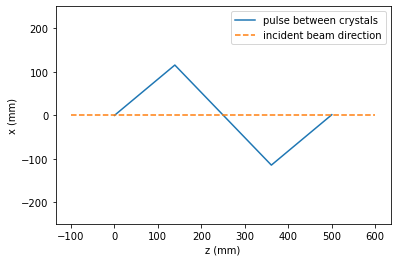

In [5]:
##### beamline crystal calculations
''' input parameters '''
name_HHLM = ['HHLM1', 'HHLM2', 'HHLM3', 'HHLM4']
thetaB_list_HHLM = np.array([thetaB220, thetaB440, thetaB440, thetaB220])
ang_asym_list_HHLM = np.deg2rad([17, 0, 0, -17])
ang_dif_pl_list_HHLM = np.array([np.pi/2, -np.pi/2, np.pi/2, -np.pi/2])

name_HRM = ['C1', 'C2', 'C3', 'C4']
thetaB_list_HRM = np.array([thetaB440, thetaB440, thetaB440, thetaB440])
ang_asym_list_HRM = np.deg2rad([0, -29.5, 0, 29.5])
ang_dif_pl_list_HRM = np.array([np.pi/2, -np.pi/2, -np.pi/2, np.pi/2])
  
''' var_param '''
nv_list_HHLM = []; tv_list_HHLM = []; ang_in_HHLM = []
for i in range(len(name_HHLM)):
    thetaB = thetaB_list_HHLM[i]
    ang_asym = ang_asym_list_HHLM[i]
    ang_dif_pl = ang_dif_pl_list_HHLM[i]
    nv, tv, ang_in = calc_crystal_orientation(thetaB, ang_asym, ang_dif_pl)
    nv_list_HHLM.append(nv)
    tv_list_HHLM.append(tv)
    ang_in_HHLM.append(ang_in)

print('HHLM var_param\n',
      'nv: \n{}\n'.format(np.round(nv_list_HHLM,3)),
      'tv: \n{}\n'.format(np.round(tv_list_HHLM,3)),
      'incident angle: \n{}\n'.format(np.round(ang_in_HHLM,3)))

nv_list_HRM = []; tv_list_HRM = []; ang_in_HRM = []
for i in range(len(name_HRM)):
    thetaB = thetaB_list_HRM[i]
    ang_asym = ang_asym_list_HRM[i]
    ang_dif_pl = ang_dif_pl_list_HRM[i]
    nv, tv, ang_in = calc_crystal_orientation(thetaB, ang_asym, ang_dif_pl)
    nv_list_HRM.append(nv)
    tv_list_HRM.append(tv)
    ang_in_HRM.append(ang_in)
    
print('HRM var_param\n',
      'nv: \n{}\n'.format(np.round(nv_list_HRM,3)),
      'tv: \n{}\n'.format(np.round(tv_list_HRM,3)),
      'incident angle: \n{}\n'.format(np.round(ang_in_HRM,3)))

''' scale factors '''
b_factor_HHLM = calc_b_factor(thetaB_list_HHLM,ang_asym_list_HHLM).max()
x_scaling_HHLM = calc_scale_factor(b_factor_HHLM)
t_stretching_HHLM = calc_t_stretching(thetaB_list_HHLM,ang_asym_list_HHLM, range_x=range_x).max()
z_scaling_HHLM = np.max([np.round(t_stretching_HHLM/t_window),1.])

print('HHLM scaling\n',
      'b factor: {}\n'.format(round(b_factor_HHLM,2)),
      't stretching: {}fs\n'.format(round(t_stretching_HHLM*1e15,2)),
      'x scale: {}, z scale: {}\n'.format(x_scaling_HHLM, z_scaling_HHLM))

b_factor_HRM = calc_b_factor(thetaB_list_HRM,ang_asym_list_HRM).max()
x_scaling_HRM = calc_scale_factor(b_factor_HRM)
t_stretching_HRM = calc_t_stretching(thetaB_list_HRM,ang_asym_list_HRM, range_x=range_x).max()
z_scaling_HRM = np.max([np.round(t_stretching_HRM/t_window),1.])

print('HRM scaling\n',
      'b factor: {}\n'.format(round(b_factor_HRM,2)),
      't stretching: {}fs\n'.format(round(t_stretching_HRM*1e15,2)),
      'x scale: {}, z scale: {}\n'.format(x_scaling_HRM, z_scaling_HRM))

''' HHLM positions '''
zlist = np.array([0, 139, 361, 500])    # crystal position in lab frame [mm]

# beam direction calculation
for i in range(len(zlist)):
    # loop through crystals and calculates beam direction
    if i == 0:
        v_in = [0,0,1]
        v_out = calc_direction_output(v_in, thetaB_list_HHLM[i], ang_dif_pl = ang_dif_pl_list_HHLM[i])
        beam_dir_HHLM = np.array([v_out])
    else:
        v_in = beam_dir_HHLM[i-1]
        v_out = calc_direction_output(v_in, thetaB_list_HHLM[i], ang_dif_pl = ang_dif_pl_list_HHLM[i])
        beam_dir_HHLM = np.append(beam_dir_HHLM, [v_out], axis=0)

# beam path calculation
driftz = zlist[1:] - zlist[:-1]
drift_list = []
beam_pos = np.zeros([1,3])

for i in range(len(driftz)):
    beam_dir = beam_dir_HHLM[i]
    drift = driftz[i]/beam_dir[-1]
    drift_list = np.append(drift_list, drift)
    beam_pos = np.append(beam_pos, [beam_pos[i]+drift*beam_dir], axis=0)
drift_list = np.append(drift_list, 5000.0-np.sum(drift_list))/1e3
# visualisation
plt.figure()
plt.plot(beam_pos[:,-1], -beam_pos[:,0],label='pulse between crystals')
plt.plot((np.asarray([min(beam_pos[:,-1])-100,max(beam_pos[:,-1])+100])),[0,0],'--',label='incident beam direction')
plt.legend(); plt.xlabel('z (mm)'); plt.ylabel('x (mm)'); plt.axis('equal')


In [6]:
##### introduce errors
if err_E != 0.: print('energy error added in var_param automatically')
    
if err_f0!= 0.:
    fCRL_list[0] += err_f0
    print('collimation lens focal distance error added to var_param')

if err_f1!= 0.: print('crystal-lens distance error added in var_param automatically')
    
if err_delta!= 0:
    for i in range(len(name_HHLM)):
        if cname == name_HHLM[i]:
            thetaB = thetaB_list_HHLM[i]
            ang_asym = ang_asym_list_HHLM[i]
            ang_dif_pl = ang_dif_pl_list_HHLM[i]
            nv, tv, ang_in = calc_crystal_orientation(thetaB, ang_asym, ang_dif_pl, delta=err_delta)
            nv_list_HHLM[i] = nv
            tv_list_HHLM[i] = tv
            ang_in_HHLM[i] = ang_in
    for i in range(len(name_HRM)):
        if cname == name_HRM[i]:
            thetaB = thetaB_list_HRM[i]
            ang_asym = ang_asym_list_HRM[i]
            ang_dif_pl = ang_dif_pl_list_HRM[i]
            nv, tv, ang_in = calc_crystal_orientation(thetaB, ang_asym, ang_dif_pl, delta=err_delta)
            nv_list_HRM[i] = nv
            tv_list_HRM[i] = tv
            ang_in_HRM[i] = ang_in
    print('crystal alignment error added to var_param')
    
if err_miscut != 0:
    for i in range(len(name_HHLM)):
        if cname == name_HHLM[i]:
            ang_asym_list_HHLM[i] += err_miscut
            thetaB = thetaB_list_HHLM[i]
            ang_asym = ang_asym_list_HHLM[i]
            ang_dif_pl = ang_dif_pl_list_HHLM[i]
            nv, tv, ang_in = calc_crystal_orientation(thetaB, ang_asym, ang_dif_pl)
            nv_list_HHLM[i] = nv
            tv_list_HHLM[i] = tv
            ang_in_HHLM[i] = ang_in
    for i in range(len(name_HRM)):
        if cname == name_HRM[i]:
            ang_asym_list_HRM[i] += err_miscut
            thetaB = thetaB_list_HRM[i]
            ang_asym = ang_asym_list_HRM[i]
            ang_dif_pl = ang_dif_pl_list_HRM[i]
            nv, tv, ang_in = calc_crystal_orientation(thetaB, ang_asym, ang_dif_pl)
            nv_list_HRM[i] = nv
            tv_list_HRM[i] = tv
            ang_in_HRM[i] = ang_in
    print('crystal miscut error added to var_param\n')


In [7]:
# I/O
def mkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)

for dir_name in [dir_output, dir_case, dir_param, dir_plot]:
    mkdir(dir_name); print('directory created: {}\n'.format(dir_name))


directory created: output/

directory created: output/HRM_mir/

directory created: output/HRM_mir/400.0fs/

directory created: output/HRM_mir/400.0fs/16000.0fs_100.0meV/



In [8]:
## define bl CC1
def set_optics_CRL0_before_C1(v=None):
    el = []
    pp = []
    names = ['CRL','CRL_C1']
    for el_name in names:
        if el_name == 'CRL':
            # CRL: crl 290.0m
            el.append(srwlib.srwl_opt_setup_CRL(
                _foc_plane=v.op_CRL_foc_plane,
                _delta=v.op_CRL_delta,
                _atten_len=v.op_CRL_atten_len,
                _shape=v.op_CRL_shape,
                _apert_h=v.op_CRL_apert_h,
                _apert_v=v.op_CRL_apert_v,
                _r_min=v.op_CRL_r_min,
                _n=v.op_CRL_n,
                _wall_thick=v.op_CRL_wall_thick,
                _xc=v.op_CRL_x,
                _yc=v.op_CRL_y,
            ))
            pp.append(v.op_CRL_pp)
        elif el_name == 'CRL_C1':
            # CRL_C1: drift 290.0m
            el.append(srwlib.SRWLOptD(
                _L=10.,
            ))
            pp.append(v.op_CRL_C1_pp)
    return srwlib.SRWLOptC(el, pp)


def set_optics_C1_before_C2(v=None):
    el = []
    pp = []
    names = ['C1', 'C1_C2']
    for el_name in names:
        if el_name == 'C1':
            # C1: crystal 300.0m
            crystal = srwlib.SRWLOptCryst(
                _d_sp=v.op_C1_d_sp,
                _psi0r=v.op_C1_psi0r,
                _psi0i=v.op_C1_psi0i,
                _psi_hr=v.op_C1_psiHr,
                _psi_hi=v.op_C1_psiHi,
                _psi_hbr=v.op_C1_psiHBr,
                _psi_hbi=v.op_C1_psiHBi,
                _tc=v.op_C1_tc,
                _ang_as=v.op_C1_ang_as,
                _nvx=v.op_C1_nvx,
                _nvy=v.op_C1_nvy,
                _nvz=v.op_C1_nvz,
                _tvx=v.op_C1_tvx,
                _tvy=v.op_C1_tvy,
                _uc=v.op_C1_uc,
                _e_avg=v.op_C1_energy,
                _ang_roll=v.op_C1_diffractionAngle
            )
            el.append(crystal)
            pp.append(v.op_C1_pp)

        elif el_name == 'C1_C2':
            # C1_C2: drift 300.0m
            el.append(srwlib.SRWLOptD(
                _L=v.op_C1_C2_L,
            ))
            pp.append(v.op_C1_C2_pp)
    return srwlib.SRWLOptC(el, pp)


def set_optics_C2_before_MIR1(v=None):
    el = []
    pp = []
    names = ['C2', 'C2_MIR1']
    for el_name in names:
        if el_name == 'C2':
            # C2: crystal 300.2m
            crystal = srwlib.SRWLOptCryst(
                _d_sp=v.op_C2_d_sp,
                _psi0r=v.op_C2_psi0r,
                _psi0i=v.op_C2_psi0i,
                _psi_hr=v.op_C2_psiHr,
                _psi_hi=v.op_C2_psiHi,
                _psi_hbr=v.op_C2_psiHBr,
                _psi_hbi=v.op_C2_psiHBi,
                _tc=v.op_C2_tc,
                _ang_as=v.op_C2_ang_as,
                _nvx=v.op_C2_nvx,
                _nvy=v.op_C2_nvy,
                _nvz=v.op_C2_nvz,
                _tvx=v.op_C2_tvx,
                _tvy=v.op_C2_tvy,
                _uc=v.op_C2_uc,
                _e_avg=v.op_C2_energy,
                _ang_roll=v.op_C2_diffractionAngle
            )
            el.append(crystal)
            pp.append(v.op_C2_pp)
        elif el_name == 'C2_MIR1':
            # C2_MIR1: drift 300.2m
            el.append(srwlib.SRWLOptD(
                _L=v.op_C2_MIR1_L,
            ))
            pp.append(v.op_C2_MIR1_pp)
    return srwlib.SRWLOptC(el, pp)


## define bl telescope
def set_optics_MIR1_focus(v=None):
    el = []
    pp = []
    names = ['MIR1', 'MIR1_Slit']
    for el_name in names:
        if el_name == 'MIR1':
            # MIR1: ellipsoidMirror 310.2m
            el.append(srwlib.SRWLOptMirEl(
                _p=v.op_MIR1_p,
                _q=v.op_MIR1_q,
                _ang_graz=v.op_MIR1_ang,
                _size_tang=v.op_MIR1_size_tang,
                _size_sag=v.op_MIR1_size_sag,
                _nvx=v.op_MIR1_nvx,
                _nvy=v.op_MIR1_nvy,
                _nvz=v.op_MIR1_nvz,
                _tvx=v.op_MIR1_tvx,
                _tvy=v.op_MIR1_tvy,
                _x=v.op_MIR1_x,
                _y=v.op_MIR1_y,
            ))
            pp.append(v.op_MIR1_pp)
        elif el_name == 'MIR1_Slit':
            # MIR1_Slit: drift 310.2m
            el.append(srwlib.SRWLOptD(
                _L=v.op_MIR1_Slit_L,
            ))
            pp.append(v.op_MIR1_Slit_pp)
    return srwlib.SRWLOptC(el, pp)


def set_optics_slit(v=None, xc=0, yc=0, d_slit=7e-6):
    el = []
    pp = []
    names = ['Slit']
    for el_name in names:
        if el_name == 'Slit':
            # Slit: aperture 320.2m
            el.append(srwlib.SRWLOptA(
                _shape=v.op_Slit_shape,
                _ap_or_ob='a',
                _Dx=d_slit,
                _Dy=v.op_Slit_Dy,
                _x=xc,
                _y=yc,
            ))
            pp.append(v.op_Slit_pp)
    return srwlib.SRWLOptC(el, pp)


def set_optics_slit_before_MIR2(v=None):
    el = []
    pp = []
    names = ['Slit_MIR2']
    for el_name in names:
        if el_name == 'Slit_MIR2':
            # Slit_MIR2: drift 320.2m
            el.append(srwlib.SRWLOptD(
                _L=v.op_Slit_MIR2_L,
            ))
            pp.append(v.op_Slit_MIR2_pp)
    return srwlib.SRWLOptC(el, pp)


def set_optics_MIR2_before_C3(v=None):
    el = []
    pp = []
    names = ['MIR2', 'MIR2_C3']
    for el_name in names:
        if el_name == 'MIR2':
            # MIR2: ellipsoidMirror 330.2m
            el.append(srwlib.SRWLOptMirEl(
                _p=v.op_MIR2_p,
                _q=v.op_MIR2_q,
                _ang_graz=v.op_MIR2_ang,
                _size_tang=v.op_MIR2_size_tang,
                _size_sag=v.op_MIR2_size_sag,
                _nvx=v.op_MIR2_nvx,
                _nvy=v.op_MIR2_nvy,
                _nvz=v.op_MIR2_nvz,
                _tvx=v.op_MIR2_tvx,
                _tvy=v.op_MIR2_tvy,
                _x=v.op_MIR2_x,
                _y=v.op_MIR2_y,
            ))
            pp.append(v.op_MIR2_pp)
        elif el_name == 'MIR2_C3':
            # MIR2_C3: drift 330.2m
            el.append(srwlib.SRWLOptD(
                _L=v.op_MIR2_C3_L,
            ))
            pp.append(v.op_MIR2_C3_pp)
    return srwlib.SRWLOptC(el, pp)


## define bl CC2
def set_optics_C3_before_C4(v=None):
    el = []
    pp = []
    names = ['C3', 'C3_C4']
    for el_name in names:
        if el_name == 'C3':
            # C3: crystal 340.2m
            crystal = srwlib.SRWLOptCryst(
                _d_sp=v.op_C3_d_sp,
                _psi0r=v.op_C3_psi0r,
                _psi0i=v.op_C3_psi0i,
                _psi_hr=v.op_C3_psiHr,
                _psi_hi=v.op_C3_psiHi,
                _psi_hbr=v.op_C3_psiHBr,
                _psi_hbi=v.op_C3_psiHBi,
                _tc=v.op_C3_tc,
                _ang_as=v.op_C3_ang_as,
                _nvx=v.op_C3_nvx,
                _nvy=v.op_C3_nvy,
                _nvz=v.op_C3_nvz,
                _tvx=v.op_C3_tvx,
                _tvy=v.op_C3_tvy,
                _uc=v.op_C3_uc,
                _e_avg=v.op_C3_energy,
                _ang_roll=v.op_C3_diffractionAngle
            )
            el.append(crystal)
            pp.append(v.op_C3_pp)

        elif el_name == 'C3_C4':
            # C3_C4: drift 340.2m
            el.append(srwlib.SRWLOptD(
                _L=v.op_C3_C4_L,
            ))
            pp.append(v.op_C3_C4_pp)
    return srwlib.SRWLOptC(el, pp)


def set_optics_C4_output(v=None):
    el = []
    pp = []
    names = ['C4']
    for el_name in names:
        if el_name == 'C4':
            # C4: crystal 340.4m
            crystal = srwlib.SRWLOptCryst(
                _d_sp=v.op_C4_d_sp,
                _psi0r=v.op_C4_psi0r,
                _psi0i=v.op_C4_psi0i,
                _psi_hr=v.op_C4_psiHr,
                _psi_hi=v.op_C4_psiHi,
                _psi_hbr=v.op_C4_psiHBr,
                _psi_hbi=v.op_C4_psiHBi,
                _tc=v.op_C4_tc,
                _ang_as=v.op_C4_ang_as,
                _nvx=v.op_C4_nvx,
                _nvy=v.op_C4_nvy,
                _nvz=v.op_C4_nvz,
                _tvx=v.op_C4_tvx,
                _tvy=v.op_C4_tvy,
                _uc=v.op_C4_uc,
                _e_avg=v.op_C4_energy,
                _ang_roll=v.op_C4_diffractionAngle
            )
            el.append(crystal)
            pp.append(v.op_C4_pp)
    pp.append(v.op_fin_pp)
    return srwlib.SRWLOptC(el, pp)

In [9]:
varParam = srwl_bl.srwl_uti_ext_options([
    ['name', 's', 'full_beamline', 'simulation name'],

#---Data Folder
    ['fdir', 's', '', 'folder (directory) name for reading-in input and saving output data files'],


    ['gbm_x', 'f', 0.0, 'average horizontal coordinates of waist [m]'],
    ['gbm_y', 'f', 0.0, 'average vertical coordinates of waist [m]'],
    ['gbm_z', 'f', 0.0, 'average longitudinal coordinate of waist [m]'],
    ['gbm_xp', 'f', 0.0, 'average horizontal angle at waist [rad]'],
    ['gbm_yp', 'f', 0.0, 'average verical angle at waist [rad]'],
    ['gbm_ave', 'f', E+err_E, 'average photon energy [eV]'],
    ['gbm_pen', 'f', 0.001, 'energy per pulse [J]'],
    ['gbm_rep', 'f', 1, 'rep. rate [Hz]'],
    ['gbm_pol', 'f', 2, 'polarization 1- lin. hor., 2- lin. vert., 3- lin. 45 deg., 4- lin.135 deg., 5- circ. right, 6- circ. left'],
    ['gbm_sx', 'f', 9.787229999999999e-06, 'rms beam size vs horizontal position [m] at waist (for intensity)'],
    ['gbm_sy', 'f', 9.787229999999999e-06, 'rms beam size vs vertical position [m] at waist (for intensity)'],
    ['gbm_st', 'f', sigT, 'rms pulse duration [s] (for intensity)'],
    ['gbm_mx', 'f', 0, 'transverse Gauss-Hermite mode order in horizontal direction'],
    ['gbm_my', 'f', 0, 'transverse Gauss-Hermite mode order in vertical direction'],
    ['gbm_ca', 's', 'c', 'treat _sigX, _sigY as sizes in [m] in coordinate representation (_presCA="c") or as angular divergences in [rad] in angular representation (_presCA="a")'],
    ['gbm_ft', 's', 't', 'treat _sigT as pulse duration in [s] in time domain/representation (_presFT="t") or as bandwidth in [eV] in frequency domain/representation (_presFT="f")'],

#---Calculation Types
    #Single-Electron Intensity distribution vs horizontal and vertical position
    ['si', '', '', 'calculate single-e intensity distribution (without wavefront propagation through a beamline) vs horizontal and vertical position', 'store_true'],
    #Single-Electron Wavefront Propagation
    ['ws', '', '', 'calculate single-electron (/ fully coherent) wavefront propagation', 'store_true'],
    #Multi-Electron (partially-coherent) Wavefront Propagation
    ['wm', '', '', 'calculate multi-electron (/ partially coherent) wavefront propagation', 'store_true'],

    ['w_e', 'f', -pulseRange*sigT/2, 'photon energy [eV] for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_ef', 'f', pulseRange*sigT/2, 'final photon energy [eV] for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_ne', 'i', nz, 'number of points vs photon energy for calculation of intensity distribution'],
    ['w_x', 'f', 0.0, 'central horizontal position [m] for calculation of intensity distribution'],
    ['w_rx', 'f', range_x, 'range of horizontal position [m] for calculation of intensity distribution'],
    ['w_nx', 'i', nx, 'number of points vs horizontal position for calculation of intensity distribution'],
    ['w_y', 'f', 0.0, 'central vertical position [m] for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_ry', 'f', range_y, 'range of vertical position [m] for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_ny', 'i', ny, 'number of points vs vertical position for calculation of intensity distribution'],
    ['w_smpf', 'f', factor, 'sampling factor for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_meth', 'i', 2, 'method to use for calculation of intensity distribution vs horizontal and vertical position: 0- "manual", 1- "auto-undulator", 2- "auto-wiggler"'],
    ['w_prec', 'f', 0.01, 'relative precision for calculation of intensity distribution vs horizontal and vertical position'],

    ['w_ft', 's', 't', 'presentation/domain: "f"- frequency (photon energy), "t"- time'],

    ['w_u', 'i', 2, 'electric field units: 0- arbitrary, 1- sqrt(Phot/s/0.1%bw/mm^2), 2- sqrt(J/eV/mm^2) or sqrt(W/mm^2), depending on representation (freq. or time)'],
    ['si_pol', 'i', 6, 'polarization component to extract after calculation of intensity distribution: 0- Linear Horizontal, 1- Linear Vertical, 2- Linear 45 degrees, 3- Linear 135 degrees, 4- Circular Right, 5- Circular Left, 6- Total'],
    ['si_type', 'i', 0, 'type of a characteristic to be extracted after calculation of intensity distribution: 0- Single-Electron Intensity, 1- Multi-Electron Intensity, 2- Single-Electron Flux, 3- Multi-Electron Flux, 4- Single-Electron Radiation Phase, 5- Re(E): Real part of Single-Electron Electric Field, 6- Im(E): Imaginary part of Single-Electron Electric Field, 7- Single-Electron Intensity, integrated over Time or Photon Energy'],
    
    ['si_fn', 's', 'res_int_se.dat', 'file name for saving calculated single-e intensity distribution (without wavefront propagation through a beamline) vs horizontal and vertical position'],
    ['si_pl', 's', '', 'plot the input intensity distributions in graph(s): ""- dont plot, "x"- vs horizontal position, "y"- vs vertical position, "xy"- vs horizontal and vertical position'],
    ['ws_fni', 's', 'res_int_pr_se.dat', 'file name for saving propagated single-e intensity distribution vs horizontal and vertical position'],
    ['ws_pl', 's', '', 'plot the resulting intensity distributions in graph(s): ""- dont plot, "x"- vs horizontal position, "y"- vs vertical position, "xy"- vs horizontal and vertical position'],

    #to add options
    ['op_r', 'f', 290.0, 'longitudinal position of the first optical element [m]'],
    # Former appParam:
    ['rs_type', 's', 'g', 'source type, (u) idealized undulator, (t), tabulated undulator, (m) multipole, (g) gaussian beam'],

#---Beamline optics:
    # CRL: crl
    ['op_CRL_foc_plane', 'f', 1, 'focalPlane'],
    ['op_CRL_delta', 'f', 3.791135e-06, 'refractiveIndex'],
    ['op_CRL_atten_len', 'f', 0.008387, 'attenuationLength'],
    ['op_CRL_shape', 'f', 1, 'shape'],
    ['op_CRL_apert_h', 'f', range_x, 'horizontalApertureSize'],
    ['op_CRL_apert_v', 'f', range_y, 'verticalApertureSize'],
    ['op_CRL_r_min', 'f', rCRL(fCRL_list[0], nCRL_list[0]), 'tipRadius'],
    ['op_CRL_wall_thick', 'f', 5e-05, 'tipWallThickness'],
    ['op_CRL_x', 'f', 0.0, 'horizontalOffset'],
    ['op_CRL_y', 'f', 0.0, 'verticalOffset'],
    ['op_CRL_n', 'i', nCRL_list[0], 'numberOfLenses'],

    # CRL_HHLM1: drift
    ['op_CRL_C1_L', 'f', 5.0, 'length'],

    # C1: crystal
    ['op_C1_hfn', 's', '', 'heightProfileFile'],
    ['op_C1_dim', 's', 'x', 'orientation'],
    ['op_C1_d_sp', 'f', Si440.dSp, 'dSpacing'],
    ['op_C1_psi0r', 'f', Si440.psi0r, 'psi0r'],
    ['op_C1_psi0i', 'f', Si440.psi0i, 'psi0i'],
    ['op_C1_psiHr', 'f', Si440.psiHr, 'psiHr'],
    ['op_C1_psiHi', 'f', Si440.psiHi, 'psiHi'],
    ['op_C1_psiHBr', 'f', Si440.psiHbr, 'psiHBr'],
    ['op_C1_psiHBi', 'f', Si440.psiHbi, 'psiHBi'],
    ['op_C1_tc', 'f', Si440.tc, 'crystalThickness'],
    ['op_C1_uc', 'f', Si440.uc, 'useCase'],
    ['op_C1_ang_as', 'f', ang_asym_list_HRM[0], 'asymmetryAngle'],
    ['op_C1_nvx', 'f', nv_list_HRM[0][0], 'nvx'],
    ['op_C1_nvy', 'f', nv_list_HRM[0][1], 'nvy'],
    ['op_C1_nvz', 'f', nv_list_HRM[0][2], 'nvz'],
    ['op_C1_tvx', 'f', tv_list_HRM[0][0], 'tvx'],
    ['op_C1_tvy', 'f', tv_list_HRM[0][1], 'tvy'],
    ['op_C1_ang', 'f', ang_in_HRM[0], 'grazingAngle'],
    ['op_C1_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_C1_energy', 'f', E, 'energy'],
    ['op_C1_diffractionAngle', 'f', ang_dif_pl_list_HRM[0], 'diffractionAngle'],

    # C1_C2: drift
    ['op_C1_C2_L', 'f', 0.2, 'length'],

    # C2: crystal
    ['op_C2_hfn', 's', '', 'heightProfileFile'],
    ['op_C2_dim', 's', 'x', 'orientation'],
    ['op_C2_d_sp', 'f', Si440.dSp, 'dSpacing'],
    ['op_C2_psi0r', 'f', Si440.psi0r, 'psi0r'],
    ['op_C2_psi0i', 'f', Si440.psi0i, 'psi0i'],
    ['op_C2_psiHr', 'f', Si440.psiHr, 'psiHr'],
    ['op_C2_psiHi', 'f', Si440.psiHi, 'psiHi'],
    ['op_C2_psiHBr', 'f', Si440.psiHbr, 'psiHBr'],
    ['op_C2_psiHBi', 'f', Si440.psiHbi, 'psiHBi'],
    ['op_C2_tc', 'f', Si440.tc, 'crystalThickness'],
    ['op_C2_uc', 'f', Si440.uc, 'useCase'],
    ['op_C2_ang_as', 'f', ang_asym_list_HRM[1], 'asymmetryAngle'],
    ['op_C2_nvx', 'f', nv_list_HRM[1][0], 'nvx'],
    ['op_C2_nvy', 'f', nv_list_HRM[1][1], 'nvy'],
    ['op_C2_nvz', 'f', nv_list_HRM[1][2], 'nvz'],
    ['op_C2_tvx', 'f', tv_list_HRM[1][0], 'tvx'],
    ['op_C2_tvy', 'f', tv_list_HRM[1][1], 'tvy'],
    ['op_C2_ang', 'f', ang_in_HRM[1], 'grazingAngle'],
    ['op_C2_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_C2_energy', 'f', E, 'energy'],
    ['op_C2_diffractionAngle', 'f', ang_dif_pl_list_HRM[1], 'diffractionAngle'],

    # C2_MIR1: drift
    ['op_C2_MIR1_L', 'f', fCRL_list[1]+err_f1, 'length'],
    
    # MIR1: ellipsoidMirror
    ['op_MIR1_hfn', 's', 'None', 'heightProfileFile'],
    ['op_MIR1_dim', 's', 'x', 'orientation'],
    ['op_MIR1_p', 'f', 1e5, 'firstFocusLength'],
    ['op_MIR1_q', 'f', 10.0, 'focalLength'],
    ['op_MIR1_ang', 'f', 0.0036, 'grazingAngle'],
    ['op_MIR1_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_MIR1_size_tang', 'f', 0.01, 'tangentialSize'],
    ['op_MIR1_size_sag', 'f', 0.01, 'sagittalSize'],
    ['op_MIR1_nvx', 'f', 0.9999935200069984, 'normalVectorX'],
    ['op_MIR1_nvy', 'f', 0.0, 'normalVectorY'],
    ['op_MIR1_nvz', 'f', -0.0035999922240050387, 'normalVectorZ'],
    ['op_MIR1_tvx', 'f', 0.0035999922240050387, 'tangentialVectorX'],
    ['op_MIR1_tvy', 'f', 0.0, 'tangentialVectorY'],
    ['op_MIR1_x', 'f', 0.0, 'horizontalOffset'],
    ['op_MIR1_y', 'f', 0.0, 'verticalOffset'],

    # MIR1_Slit: drift
    ['op_MIR1_Slit_L', 'f', fCRL_list[1], 'length'],

    # Slit: aperture
    ['op_Slit_shape', 's', 'r', 'shape'],
    ['op_Slit_Dx', 'f', d_slit, 'horizontalSize'],
    ['op_Slit_Dy', 'f', 0.01, 'verticalSize'],
    ['op_Slit_x', 'f', 0.0, 'horizontalOffset'],
    ['op_Slit_y', 'f', 0.0, 'verticalOffset'],

    # Slit_MIR2: drift
    ['op_Slit_MIR2_L', 'f', fCRL_list[2], 'length'],

    # MIR2: ellipsoidMirror
    ['op_MIR2_hfn', 's', '', 'heightProfileFile'],
    ['op_MIR2_dim', 's', 'x', 'orientation'],
    ['op_MIR2_p', 'f', 10.0, 'firstFocusLength'],
    ['op_MIR2_q', 'f', 1e5, 'focalLength'],
    ['op_MIR2_ang', 'f', 0.0036, 'grazingAngle'],
    ['op_MIR2_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_MIR2_size_tang', 'f', 0.01, 'tangentialSize'],
    ['op_MIR2_size_sag', 'f', 0.01, 'sagittalSize'],
    ['op_MIR2_nvx', 'f', 0.9999935200069984, 'normalVectorX'],
    ['op_MIR2_nvy', 'f', 0.0, 'normalVectorY'],
    ['op_MIR2_nvz', 'f', -0.0035999922240050387, 'normalVectorZ'],
    ['op_MIR2_tvx', 'f', -0.0035999922240050387, 'tangentialVectorX'],
    ['op_MIR2_tvy', 'f', 0.0, 'tangentialVectorY'],
    ['op_MIR2_x', 'f', 0.0, 'horizontalOffset'],
    ['op_MIR2_y', 'f', 0.0, 'verticalOffset'],

    # MIR2_C3: drift
    ['op_MIR2_C3_L', 'f', fCRL_list[2]+err_f1, 'length'],
    
    # C3: crystal
    ['op_C3_hfn', 's', '', 'heightProfileFile'],
    ['op_C3_dim', 's', 'x', 'orientation'],
    ['op_C3_d_sp', 'f', Si440.dSp, 'dSpacing'],
    ['op_C3_psi0r', 'f', Si440.psi0r, 'psi0r'],
    ['op_C3_psi0i', 'f', Si440.psi0i, 'psi0i'],
    ['op_C3_psiHr', 'f', Si440.psiHr, 'psiHr'],
    ['op_C3_psiHi', 'f', Si440.psiHi, 'psiHi'],
    ['op_C3_psiHBr', 'f', Si440.psiHbr, 'psiHBr'],
    ['op_C3_psiHBi', 'f', Si440.psiHbi, 'psiHBi'],
    ['op_C3_tc', 'f', Si440.tc, 'crystalThickness'],
    ['op_C3_uc', 'f', Si440.uc, 'useCase'],
    ['op_C3_ang_as', 'f', ang_asym_list_HRM[2], 'asymmetryAngle'],
    ['op_C3_nvx', 'f', nv_list_HRM[2][0], 'nvx'],
    ['op_C3_nvy', 'f', nv_list_HRM[2][1], 'nvy'],
    ['op_C3_nvz', 'f', nv_list_HRM[2][2], 'nvz'],
    ['op_C3_tvx', 'f', tv_list_HRM[2][0], 'tvx'],
    ['op_C3_tvy', 'f', tv_list_HRM[2][1], 'tvy'],
    ['op_C3_ang', 'f', ang_in_HRM[2], 'grazingAngle'],
    ['op_C3_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_C3_energy', 'f', E, 'energy'],
    ['op_C3_diffractionAngle', 'f', ang_dif_pl_list_HRM[2], 'diffractionAngle'],

    # C3_C4: drift
    ['op_C3_C4_L', 'f', 0.2, 'length'],

    # C4: crystal
    ['op_C4_hfn', 's', '', 'heightProfileFile'],
    ['op_C4_dim', 's', 'x', 'orientation'],
    ['op_C4_d_sp', 'f', Si440.dSp, 'dSpacing'],
    ['op_C4_psi0r', 'f', Si440.psi0r, 'psi0r'],
    ['op_C4_psi0i', 'f', Si440.psi0i, 'psi0i'],
    ['op_C4_psiHr', 'f', Si440.psiHr, 'psiHr'],
    ['op_C4_psiHi', 'f', Si440.psiHi, 'psiHi'],
    ['op_C4_psiHBr', 'f', Si440.psiHbr, 'psiHBr'],
    ['op_C4_psiHBi', 'f', Si440.psiHbi, 'psiHBi'],
    ['op_C4_tc', 'f', Si440.tc, 'crystalThickness'],
    ['op_C4_uc', 'f', Si440.uc, 'useCase'],
    ['op_C4_ang_as', 'f', ang_asym_list_HRM[3], 'asymmetryAngle'],
    ['op_C4_nvx', 'f', nv_list_HRM[3][0], 'nvx'],
    ['op_C4_nvy', 'f', nv_list_HRM[3][1], 'nvy'],
    ['op_C4_nvz', 'f', nv_list_HRM[3][2], 'nvz'],
    ['op_C4_tvx', 'f', tv_list_HRM[3][0], 'tvx'],
    ['op_C4_tvy', 'f', tv_list_HRM[3][1], 'tvy'],
    ['op_C4_ang', 'f', ang_in_HRM[3], 'grazingAngle'],
    ['op_C4_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_C4_energy', 'f', E, 'energy'],
    ['op_C4_diffractionAngle', 'f', ang_dif_pl_list_HRM[3], 'diffractionAngle'],

    # C4_After_HRM: drift
    ['op_C4_After_HRM_L', 'f', 10.0, 'length'],
    
#---Propagation parameters
#                                   [0][1] [2] [3][4] [5]  [6]  [7]  [8]  [9] [10] [11]
    ['op_CRL_pp', 'f',              [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'CRL'],
    ['op_CRL_C1_pp', 'f',           [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'CRL_HHLM1'],
    ['op_C1_pp', 'f',               [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'C1'],
    ['op_C1_C2_pp', 'f',            [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'C1_C2'],
    ['op_C2_pp', 'f',               [0, 0, 1.0, 0, 0, 4*x_scaling_HRM, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'C2'],
    ['op_C2_MIR1_pp', 'f',          [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'C2_MIR1'],
    ['op_MIR1_pp', 'f',             [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'MIR1'],
    ['op_MIR1_Slit_pp', 'f',        [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'MIR1_Slit'],
    ['op_Slit_pp', 'f',             [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'Slit'],
    ['op_Slit_MIR2_pp', 'f',        [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'Slit_MIR2'],
    ['op_MIR2_pp', 'f',             [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'MIR2'],
    ['op_MIR2_C3_pp', 'f',          [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'MIR2_C3'],
    ['op_C3_pp', 'f',               [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'C3'],
    ['op_C3_C4_pp', 'f',            [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'C3_C4'],
    ['op_C4_pp', 'f',               [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'C4'],
    ['op_C4_After_HRM_pp', 'f',     [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'C4_After_HRM'],
    ['op_fin_pp', 'f',              [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'final post-propagation (resize) parameters'],

    #[ 0]: Auto-Resize (1) or not (0) Before propagation
    #[ 1]: Auto-Resize (1) or not (0) After propagation
    #[ 2]: Relative Precision for propagation with Auto-Resizing (1. is nominal)
    #[ 3]: Allow (1) or not (0) for semi-analytical treatment of the quadratic (leading) phase terms at the propagation
    #[ 4]: Do any Resizing on Fourier side, using FFT, (1) or not (0)
    #[ 5]: Horizontal Range modification factor at Resizing (1. means no modification)
    #[ 6]: Horizontal Resolution modification factor at Resizing
    #[ 7]: Vertical Range modification factor at Resizing
    #[ 8]: Vertical Resolution modification factor at Resizing
    #[ 9]: Type of wavefront Shift before Resizing (not yet implemented)
    #[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
    #[11]: New Vertical wavefront Center position after Shift (not yet implemented)
    #[12]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Horizontal Coordinate
    #[13]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Vertical Coordinate
    #[14]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Longitudinal Coordinate
    #[15]: Optional: Orientation of the Horizontal Base vector of the Output Frame in the Incident Beam Frame: Horizontal Coordinate
    #[16]: Optional: Orientation of the Horizontal Base vector of the Output Frame in the Incident Beam Frame: Vertical Coordinate
])


In [10]:
def plot_wfr_diagnostic(_wfr, label=None, dir_plot=None, if_slice=1, if_log=0, i=0, i_start=0):
    '''
    if_slice: y = 0 slice only or full projection
    if_log: log scale in imshow plots
    i: plot index, make I/O easier
    i_start: minimum plot index, only indices >= i_start will be plotted
    '''
    if i < i_start: print('plot skipped')
    else:
        np.seterr(divide = 'ignore')
        nx, ny, nz = get_dimension(_wfr)
        # I/O plot name
        nx, ny, nz = get_dimension(_wfr)    # get dimension
        if if_log == 1:
            pltname = '{}_{}_nx{}_ny{}_nz{}_log.png'.format(i,label,nx,ny,nz)
        else:
            pltname = '{}_{}_nx{}_ny{}_nz{}.png'.format(i,label,nx,ny,nz)

        ''' some calculations '''
        # space
        title_space = label + ', '
        axis_x, axis_y = get_axis_sp(_wfr)      # spatial axis [m]
        res_x = round(np.abs(axis_x[1] - axis_x[0])*1e6,2)  # spatial resolution
        try:
            cent_x, cent_y, fwhm_x, fwhm_y = fit_pulse_position(_wfr)   # fit for pulse position and width
            xstart = cent_x - fwhm_x*10; xfin = cent_x + fwhm_x*10
            ystart = cent_y - fwhm_y*10; yfin = cent_y + fwhm_y*10
            title_space+= 'x size: {}um, '.format(round(fwhm_x*1e6,2))
        except:
            xstart = axis_x.min(); xfin = axis_x.max()
            ystart = axis_y.min(); yfin = axis_y.max()
        xstart = max(axis_x.min()*1e6, xstart*1e6); xfin = min(axis_x.max()*1e6, xfin*1e6)
        ystart = max(axis_y.min()*1e6, ystart*1e6); yfin = min(axis_y.max()*1e6, yfin*1e6)
        title_space += 'resolution: {}um'.format(res_x)

        # energy
        title_energy = ''
        axis_ev = get_axis_ev(_wfr)     # energy axis [eV]
        axis_ev = axis_ev - axis_ev[int(axis_ev.size/2)]        # shifted energy axis
        res_ev = round(np.abs(axis_ev[1] - axis_ev[0])*1e3,2)   # energy resolution
        try:
            cent_E, fwhm_E = fit_pulse_bandwidth(_wfr)      # fit for pulse central energy and bandwidth
            Estart = -fwhm_E*10*1e3; Efin = fwhm_E*10*1e3
            title_energy += 'bandwidth: {}meV, '.format(round(fwhm_E*1e3,2))
        except:
            Estart = axis_ev.min()*1e3; Efin = axis_ev.max()*1e3
        Estart = max(axis_ev.min()*1e3, Estart); Efin = min(axis_ev.max()*1e3, Efin)
        title_energy += 'resolution: {}meV'.format(res_ev)

        # time
        title_time = ''
        axis_t = get_axis_t(_wfr)       # time axis [s]
        res_t = round(np.abs(axis_t[1] - axis_t[0])*1e15,2)     # time resolution
        try:
            cent_t, fwhm_t = fit_pulse_duration(_wfr)       # fit for pulse duration
            tstart = cent_t - fwhm_t*10; tfin = cent_t + fwhm_t*10
            title_time += 'duration: {}fs, '.format(round(fwhm_t,2))
        except:
            tstart = axis_t.min()*1e15; tfin = axis_t.max()*1e15; fwhm_t = None
        tstart = max(axis_t.min()*1e15, tstart); tfin = min(axis_t.max()*1e15, tfin)
        try:
            tilt = round(fit_pulsefront_tilt(_wfr, dim='x'),2)     # [fs/um]
            title_time += 'tilt: {}fs/um, '.format(tilt)
        except:
            tilt = None
        title_time += 'resolution: {}fs'.format(res_t)

        # divergence
        try:
            h = 4.135667696e-15
            dif_lim = fwhm_t*1e-15 * fwhm_E/h*2
            print('del_t*del_E/h: {}'.format(round(dif_lim,5)))
        except:
            print('del_t*del_E/h cannot be calculated')
        
        t0 = time(); print('plotting {},\n'.format(label),
                           '[nx, ny, nz]: {}\n'.format([nx, ny, nz]),
                           'x range: {}um\n'.format(round((axis_x.max()-axis_x.min())*1e6,2)),
                           't range: {}fs\n'.format(round((axis_t.max()-axis_t.min())*1e15,2)),
                           'E range: {}meV\n'.format(round((axis_ev.max()-axis_ev.min())*1e3,2)))
        
        ''' plots '''
        plt.figure(figsize=(24,6))
        # space
        plt.subplot(1,3,1); plot_spatial_from_wf(_wfr, if_slice=if_slice, if_log=if_log)
#         plt.title(title_space); plt.axis('tight'); plt.xlim([-(range_x * x_scaling_HHLM/2)*1e6, (range_x * x_scaling_HHLM/2)*1e6])
#         plt.title(title_space); plt.axis('tight'); plt.xlim([-range_x/2*1e6, range_x/2*1e6])
        plt.title(title_space); plt.axis('tight'); plt.xlim([xstart, xfin])
        if if_slice != 1: plt.ylim([-range_y/2*1e6, range_y/2*1e6])

        # time
        plt.subplot(1,3,2); plot_tilt_from_wf(_wfr, ori='Horizontal', type='slice', if_log=if_log)
        plt.title(title_time); plt.xlim([tstart, tfin]); plt.ylim([xstart, xfin])

        # energy
        plt.subplot(1,3,3); plot_spatial_spectrum_from_wf(_wfr, ori='Horizontal', if_slice=0, if_log=if_log)
        plt.title(title_energy); plt.xlim([xstart, xfin]); plt.ylim([Estart, Efin])

        plt.savefig(dir_plot+pltname)
#         plt.close('all')
        np.seterr(divide = 'warn')
        print('plot lasted {}s\n'.format(round(time()-t0,2)))



In [11]:
def main(drift_list, if_log=1, if_slice=1, d_slit=7e-6, i_start=0, if_close=0):
    # initialization
    v = srwl_bl.srwl_uti_parse_options(varParam, use_sys_argv=True)
    v.si = True
    srwl_bl.SRWLBeamline(_name=v.name).calc_all(v)
    
    # incident beam
    wfr = v.w_res; i_plot = 1
    plot_wfr_diagnostic(wfr, label='input', dir_plot=dir_plot, i=i_plot, if_log=if_log, if_slice=if_slice, i_start=i_start)
    srwlpy.SetRepresElecField(wfr, 'f')
    
    t0 = time(); print('Resizing in frequency domain: ', end='')
    srwlpy.ResizeElecField(wfr, 'f', [0, 1., z_scaling_HRM]); print('done in', round(time() - t0, 3), 's')
    
    # CC1
    label = 'before C1'; print('Propagating through {}: '.format(label), end=''); i_plot+=1; t0 = time()
    bl = set_optics_CRL0_before_C1(v); srwlpy.PropagElecField(wfr, bl); print('done in', round(time() - t0, 3), 's\n')
    plot_wfr_diagnostic(wfr, label=label, dir_plot=dir_plot, i=i_plot, if_log=if_log, if_slice=if_slice, i_start=i_start)
    
    label = 'before C2'; print('Propagating through {}: '.format(label), end=''); i_plot+=1; t0 = time()
    bl = set_optics_C1_before_C2(v); srwlpy.PropagElecField(wfr, bl); print('done in', round(time() - t0, 3), 's\n')
    plot_wfr_diagnostic(wfr, label=label, dir_plot=dir_plot, i=i_plot, if_log=if_log, if_slice=if_slice, i_start=i_start)
    
    label = 'before MIR1'; print('Propagating through {}: '.format(label), end=''); i_plot+=1; t0 = time()
    bl = set_optics_C2_before_MIR1(v); srwlpy.PropagElecField(wfr, bl); print('done in', round(time() - t0, 3), 's\n')
    plot_wfr_diagnostic(wfr, label=label, dir_plot=dir_plot, i=i_plot, if_log=if_log, if_slice=if_slice, i_start=i_start)
    
    # Telescope
    label_append = ', open'
    label = 'focal plane'+label_append; print('Propagating through {}: '.format(label), end=''); i_plot+=1; t0 = time()
    bl = set_optics_MIR1_focus(v); srwlpy.PropagElecField(wfr, bl); print('done in', round(time() - t0, 3), 's\n')
    if if_close == 1:
        label_append = ', closed'
        label = 'focal plane'+label_append; print('Propagating through slit: ', end=''); t0 = time()
        bl = set_optics_slit(v, d_slit=7e-6); srwlpy.PropagElecField(wfr, bl); print('done in', round(time() - t0, 3), 's\n')
    plot_wfr_diagnostic(wfr, label=label, dir_plot=dir_plot, i=i_plot, if_log=if_log, if_slice=if_slice, i_start=i_start)
    
    label = 'before MIR2'+label_append; print('Propagating through {}: '.format(label), end=''); i_plot+=1; t0 = time()
    bl = set_optics_slit_before_MIR2(v); srwlpy.PropagElecField(wfr, bl); print('done in', round(time() - t0, 3), 's\n')
    plot_wfr_diagnostic(wfr, label=label, dir_plot=dir_plot, i=i_plot, if_log=if_log, if_slice=if_slice, i_start=i_start)
    
    label = 'before C3'+label_append; print('Propagating through {}: '.format(label), end=''); i_plot+=1; t0 = time()
    bl = set_optics_MIR2_before_C3(v); srwlpy.PropagElecField(wfr, bl); print('done in', round(time() - t0, 3), 's\n')
    plot_wfr_diagnostic(wfr, label=label, dir_plot=dir_plot, i=i_plot, if_log=if_log, if_slice=if_slice, i_start=i_start)
    
    # CC2
    label = 'before C4'+label_append; print('Propagating through {}: '.format(label), end=''); i_plot+=1; t0 = time()
    bl = set_optics_C3_before_C4(v); srwlpy.PropagElecField(wfr, bl); print('done in', round(time() - t0, 3), 's\n')
    plot_wfr_diagnostic(wfr, label=label, dir_plot=dir_plot, i=i_plot, if_log=if_log, if_slice=if_slice, i_start=i_start)
    
    t0 = time(); print('Resizing in frequency domain: ', end='')
    srwlpy.ResizeElecField(wfr, 'f', [0, 1., 2.]); print('done in', round(time() - t0, 3), 's')
    
    label = 'output'+label_append; print('Propagating through {}: '.format(label), end=''); i_plot+=1; t0 = time()
    bl = set_optics_C4_output(v); srwlpy.PropagElecField(wfr, bl); print('done in', round(time() - t0, 3), 's\n')
    plot_wfr_diagnostic(wfr, label=label, dir_plot=dir_plot, i=i_plot, if_log=if_log, if_slice=if_slice, i_start=i_start)


In [ ]:
## open slit
if __name__ == '__main__':
    time_stamp=time()
    main(drift_list, if_log=if_log, if_slice=0, d_slit=0.1, i_start=5, if_close=0)
    print('\n\neverything lasted: {}s'.format(round(time()-time_stamp,2)))


Gaussian beam electric field calculation ... completed (lasted 1.985 s)
Extracting intensity and saving it to a file ... completed (lasted 14.391 s)
plot skipped
Resizing in frequency domain: done in 0.003 s
Propagating through before C1: Optical Element Setup: CRL Focal Length: 290.0 m
done in 8.292 s

plot skipped
Propagating through before C2: done in 8.547 s

plot skipped
Propagating through before MIR1: done in 148.562 s

plot skipped
Propagating through focal plane, open: done in 57.739 s

Fit failed. Using second moment for width.
del_t*del_E/h: 1.04047
plotting focal plane, open,
 [nx, ny, nz]: [16384, 8, 400]
 x range: 1069.24um
 t range: 15966.03fs
 E range: 103.09meV

plot lasted 106.66s

Propagating through before MIR2, open: done in 32.531 s

Fit failed. Using second moment for width.
del_t*del_E/h: 1.04054
plotting before MIR2, open,
 [nx, ny, nz]: [16384, 8, 400]
 x range: 15603.54um
 t range: 15966.03fs
 E range: 103.09meV

plot lasted 109.13s

Propagating through befor

In [ ]:
# import winsound
# for i in range(3):
#     winsound.Beep(500,1000)
#     winsound.Beep(1000,1000)
